In [57]:
import gym 
import torch
import matplotlib.pyplot as plt
import random
from collections import deque
import copy
import IPython
    
class DuelingDQN(torch.nn.Module):
    def __init__(self, input_size, output_size, l1, l2, l3, lr):
        super().__init__()
        self.linear1 = torch.nn.Linear(input_size, l1)
        self.linear2 = torch.nn.Linear(l1, l2)
        self.value_linear = torch.nn.Linear(l2, 1)
        self.linear3 = torch.nn.Linear(l2, l3)
        self.adventage_linear = torch.nn.Linear(l3, output_size)
        
        self.loss_fn = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.epsilon = 1
        
    def evaluate_q(self, state):
        x0 = self.linear1(state)
        x0 = torch.relu(x0)
        x0 = self.linear2(x0)
        x0 = torch.relu(x0)
        x1 = self.value_linear(x0)
        x2 = self.linear3(x0)
        x2 = torch.relu(x2)
        x2 = self.adventage_linear(x2)
        x2 = x2-torch.mean(x2, dim=1, keepdim=True)
        return x1+x2
    
    def act_on_q(self, q):
        if random.random() < self.epsilon:
            action = random.randint(0, 1)
        else:
            action = q.argmax().item()
        return action
    
    def forward(self, state):
        q = self.evaluate_q(torch.Tensor(state.reshape(1, -1)))
        action = self.act_on_q(q)
        return action
        
    def learn(self, x, y):
        loss = self.loss_fn(x, y)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

def play_one_step(env, agent):
    state1 = env.env.state
    q = agent.evaluate_q(torch.Tensor(state1).view(1, -1))
    action = agent.act_on_q(q)
    state2, reward, done, info = env.step(action)
    return (state1, action, reward, state2, done, q.detach().numpy(), info)
            
def sample_experience(replay_buffer, batch_size=32):
    minibatch = random.sample(replay_buffer, batch_size)
    state1, action, reward, state2, done = (torch.Tensor(z) for z in zip(*minibatch))
    return state1, action, reward, state2, done

def update_agent(agent, target_agent, exp, gamma=0.99):
    state1, action, reward, state2, done = exp
    q1 = agent.evaluate_q(state1)
    with torch.no_grad():
        q2 = target_agent.evaluate_q(state2)
    q_max = torch.max(q2, dim=1).values
    x = q1.gather(dim=1, index=action.long().view(-1, 1)).view(-1)
    y = reward + (1 - done) * gamma * q_max
    loss = agent.learn(x, y)
    return loss

def play_n_episodes(env, policy, n=100):
    rewards = []
    for _ in range(n):
        state = env.reset()
        total_reward = 0
        while True:
            action = policy(state)
            new_state, reward, done, info = env.step(action)
            state = new_state
            total_reward += reward
            if done:
                break
        rewards.append(total_reward)
    return rewards

def naive_policy(state):
    if state[3] > 0:
        return 1
    else:
        return 0

In [43]:
env = gym.make("CartPole-v1")

agent = DuelingDQN(input_size=4, output_size=2, l1=64, l2=64, l3=128, lr=0.00025)
target_agent = copy.deepcopy(agent)

batch_size = 32
max_epochs = 2000
sync_freq = 500
buffer_len = 5000
gamma = 0.99

replay_buffer = deque(maxlen=buffer_len)
losses = []
rewards = []
mean_q_values = []
total_steps = 0

In [44]:

for epoch in range(1, max_epochs+1):
    env.reset()
    total_reward = 0
    while True:
        total_steps += 1
        (state1, action, reward, state2, done, q, info) = play_one_step(env, agent)
        replay_buffer.append((state1, action, reward, state2, done))
        total_reward += reward
        
        if len(replay_buffer) > batch_size:
            exp = sample_experience(replay_buffer, batch_size=batch_size)
            loss = update_agent(agent, target_agent, exp, gamma=gamma)
            losses.append(loss)
            mean_q_values.append(q.mean())
            if agent.epsilon > 0.1:
                agent.epsilon -= 0.0001
        
        if total_steps % sync_freq == 0:
            target_agent.load_state_dict(agent.state_dict())
            
        if done:
            break
            
    print(epoch, total_reward)
    rewards.append(total_reward)
    IPython.display.clear_output(wait=True)

2000 500.0


500.0


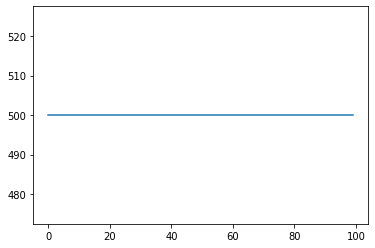

In [47]:
def max_q_policy(state):
    q = agent.evaluate_q(torch.Tensor(state))
    return q.argmax().item()

steps = play_n_episodes(env, max_q_policy)
print(sum(steps)/len(steps))
plt.plot(steps)

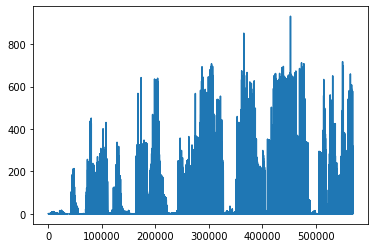

In [61]:
plt.plot(losses)

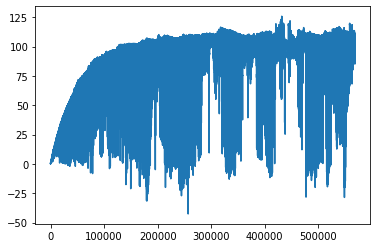

In [60]:
plt.plot(mean_q_values)

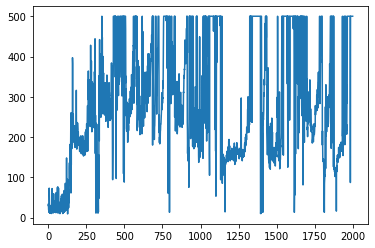

In [59]:
plt.plot(rewards)

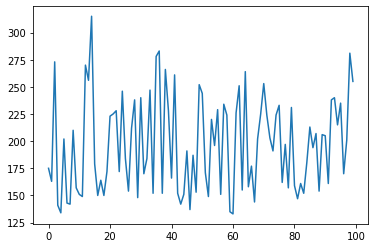

In [58]:
steps = play_n_episodes(env, naive_policy)
plt.plot(steps)